In [1]:
!pip install torchview

In [2]:
import torch.nn as nn
import torch
from torchview import draw_graph
import os
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize



RESNET MODEL IMPLEMENTATION

In [3]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
    super(ResidualBlock, self).__init__()
    self.conv1=nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    self.Conv2=nn.Sequential(
        nn.Conv2d(out_channels, out_channels,kernel_size=3,stride=1, padding=1),
        nn.BatchNorm2d(out_channels)
    )

    self.dropout = nn.Dropout(p=dropout_prob)
    self.downsample=None
    if stride !=1 or in_channels != out_channels:
      self.downsample=nn.Sequential(
          nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels)
      )
    self.Relu =nn.ReLU()
    self.out_channels=out_channels

  def forward(self, x):

      residual=x
      out=self.conv1(x)
      out=self.Conv2(out)
      out = self.dropout(out)
      if self.downsample:
        residual=self.downsample(x)

      out += residual
      out=self.Relu(out)
      return out



In [4]:
class ResNet18(nn.Module):
  def __init__(self,block,layers ,num_classes=1000):
    super(ResNet18, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
    )
    self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer0=self.make_layer(block, 64, layers[0], stride=1)
    self.layer1=self.make_layer(block, 128, layers[1], stride=2)
    self.layer2=self.make_layer(block, 256, layers[2], stride=2)
    self.layer3=self.make_layer(block, 512, layers[3], stride=2)

    self.avgpool=nn.AvgPool2d(7, stride=1)
    self.fc=nn.Linear(512, num_classes)

  def make_layer (self,block,out_channels,num_blocks,stride=1):
    layers=[]
    layers.append(block(self.in_channels, out_channels, stride))
    self.in_channels=out_channels

    for i in range(1,num_blocks):
      layers.append(block(self.in_channels, out_channels))

    return  nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x


In [5]:
model = ResNet18(ResidualBlock, [2,2,2,2])
print(model)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (Conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
      (Relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

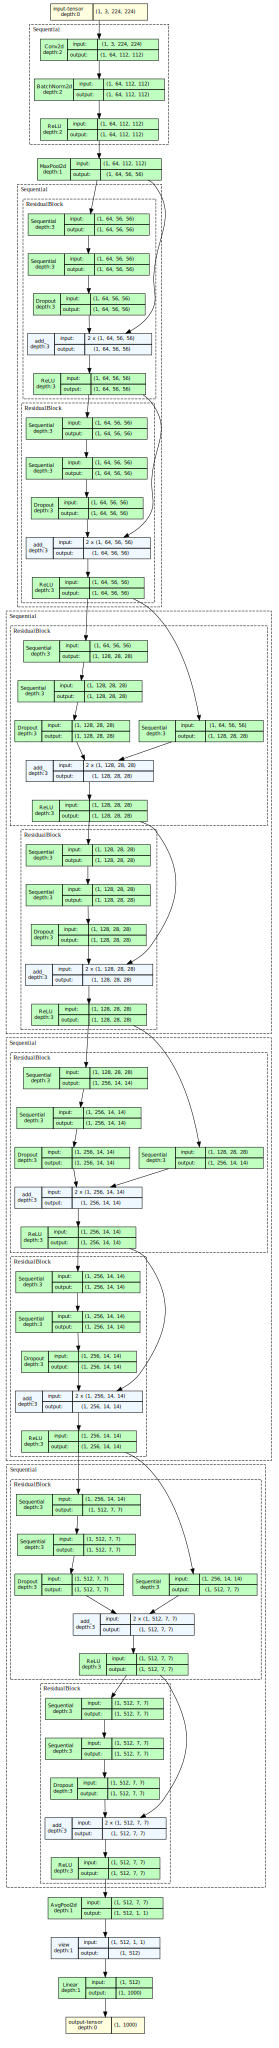

In [6]:
draw_graph(model, input_size=(1,3,224,224),expand_nested=True).visual_graph

**Data upload**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_path = '/content/drive/My Drive/dp_project/Garbage classification'


In [9]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



full_dataset = datasets.ImageFolder(data_path, transform=transform)


In [11]:
from sklearn.model_selection import train_test_split
indices = list(range(len(full_dataset)))

train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=seed)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)


In [12]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(ResidualBlock, [2, 2, 2, 2], num_classes=len(full_dataset.classes)).to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * 30
scheduler = OneCycleLR(optimizer, max_lr=0.001, total_steps=total_steps)


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30, patience=5):
    best_val_acc = 0
    wait = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            scheduler.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)

        # saving best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/resenet_model2.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping...")
                break

        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

In [16]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs=30)


Epoch 1, Loss: 22.0468, Train Acc: 31.20%, Val Acc: 15.64%
Epoch 2, Loss: 19.2738, Train Acc: 41.54%, Val Acc: 26.54%
Epoch 3, Loss: 18.0474, Train Acc: 47.40%, Val Acc: 42.18%
Epoch 4, Loss: 15.1343, Train Acc: 56.72%, Val Acc: 43.58%
Epoch 5, Loss: 14.7405, Train Acc: 60.97%, Val Acc: 36.03%
Epoch 6, Loss: 16.5506, Train Acc: 56.13%, Val Acc: 44.41%
Epoch 7, Loss: 15.0761, Train Acc: 60.13%, Val Acc: 48.60%
Epoch 8, Loss: 15.5587, Train Acc: 59.89%, Val Acc: 42.18%
Epoch 9, Loss: 14.9384, Train Acc: 60.25%, Val Acc: 53.91%
Epoch 10, Loss: 14.8353, Train Acc: 58.70%, Val Acc: 33.52%
Epoch 11, Loss: 14.5350, Train Acc: 60.67%, Val Acc: 52.79%
Epoch 12, Loss: 14.6093, Train Acc: 62.70%, Val Acc: 49.44%
Epoch 13, Loss: 13.8840, Train Acc: 63.24%, Val Acc: 59.78%
Epoch 14, Loss: 12.5490, Train Acc: 66.65%, Val Acc: 62.57%
Epoch 15, Loss: 12.0002, Train Acc: 69.22%, Val Acc: 46.09%
Epoch 16, Loss: 11.8986, Train Acc: 68.56%, Val Acc: 63.13%
Epoch 17, Loss: 11.5630, Train Acc: 70.71%, Val A

In [19]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Resnet_model2.pth',map_location=torch.device('cpu')))


<ipython-input-19-3dd3f0ab2a47>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Resnet_model2.pth',map_location=tor

<All keys matched successfully>

In [20]:
# evaluation
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 76.88%


In [21]:
#classification report
def classification_report_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

classification_report_model(model, test_loader)

              precision    recall  f1-score   support

   cardboard       0.93      0.77      0.84        66
       glass       0.74      0.82      0.78        61
       metal       0.87      0.66      0.75        59
       paper       0.69      0.88      0.77        91
     plastic       0.83      0.76      0.79        82

    accuracy                           0.79       359
   macro avg       0.81      0.78      0.79       359
weighted avg       0.80      0.79      0.79       359



100%|██████████| 12/12 [00:37<00:00,  3.16s/it]


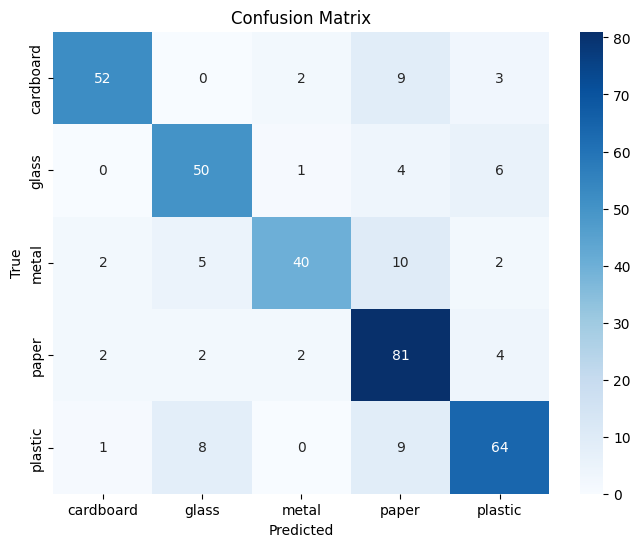

In [22]:
test_labels = []
test_preds = []


model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())


cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=train_dataset.dataset.classes,
            yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [23]:
accuracy = accuracy_score(test_labels, test_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.94%


In [24]:
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Precision: 0.81
Recall: 0.80
F1-Score: 0.80


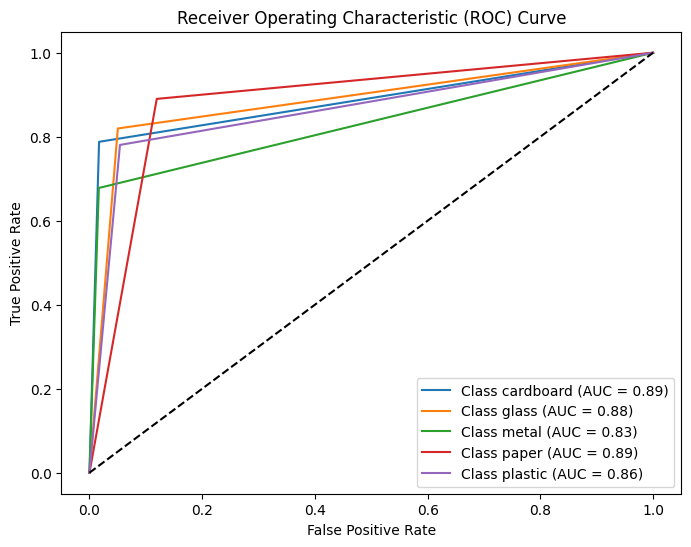

In [25]:
n_classes = len(np.unique(test_labels))
test_labels_bin = label_binarize(test_labels, classes=np.arange(n_classes))
test_preds_bin = label_binarize(test_preds, classes=np.arange(n_classes))

fpr, tpr, roc_auc = {}, {}, {}


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {train_dataset.dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

In [26]:

avg_auc = np.mean(list(roc_auc.values()))
print(f'Average AUC: {avg_auc:.2f}')


Average AUC: 0.87
